In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [3]:
def smoothen(df, columns=[], N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy().reset_index()
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [4]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360050001000,4,0.000000,0.500000,0.000000,0.000000
1,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041
2,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470493005,4,8.588745,0.020101,0.020101,2.316296
3,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471134003,4,2.479008,0.008333,0.008333,0.668563
4,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471196002,4,0.212593,0.001224,0.001224,0.057334


In [5]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df = smoothen(cdi_total_df, columns=['cdi'])
cdi_total_df.to_csv('./exports/cdi/total_all.csv')
cdi_total_df.head()

,index,date_range_start,cdi
0,0,2018-12-31 00:00:00-05:00,NaN
1,1,2019-01-07 00:00:00-05:00,NaN
2,2,2019-01-14 00:00:00-05:00,NaN
3,3,2019-01-21 00:00:00-05:00,377728.857883
4,4,2019-01-28 00:00:00-05:00,354489.822830


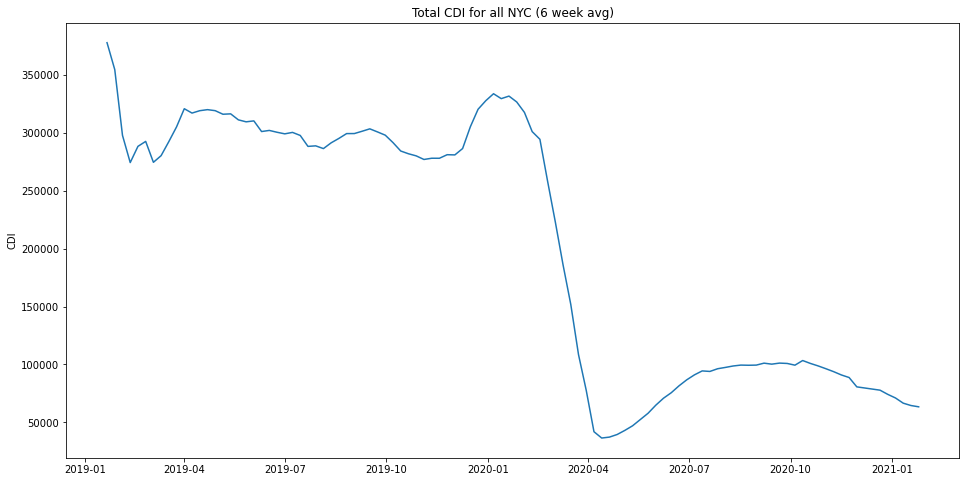

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_total_df['date_range_start'], cdi_total_df['cdi'])
ax.set_title('Total CDI for all NYC (6 week avg)')
ax.set_ylabel('CDI')
plt.show()

In [7]:
def create_diff_df(cdi_df, keep_columns=[]):
    cdi_week_df = cdi_df
    cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
    cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week
    
    # Dates are missing from December 2020!
    display(cdi_week_df.iloc[95:105])
    
    cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
    cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)
    
    display(cdi_2019_df.head())
    display(cdi_2020_df.head())
    
    cdi_diff_df = cdi_2020_df[['cdi']] - cdi_2019_df[['cdi']]
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        cdi_diff_df[keep_column] = cdi_2020_df[keep_column]
    
    display(cdi_diff_df.head())
    
    return cdi_diff_df

In [8]:
cdi_diff_df = create_diff_df(cdi_total_df)
cdi_diff_df.to_csv('./exports/cdi/diff_all.csv')

,index,date_range_start,cdi,year,week
95,95,2020-10-26 00:00:00-04:00,98758.139178,2020,44
96,96,2020-11-02 00:00:00-05:00,96327.749791,2020,45
97,97,2020-11-09 00:00:00-05:00,93801.524761,2020,46
98,98,2020-11-16 00:00:00-05:00,90959.856651,2020,47
99,99,2020-11-23 00:00:00-05:00,88742.514781,2020,48
100,100,2020-11-30 00:00:00-05:00,80668.453320,2020,49
101,101,2020-12-21 00:00:00-05:00,77825.324063,2020,52
102,102,2020-12-28 00:00:00-05:00,74210.893366,2020,53
103,103,2021-01-04 00:00:00-05:00,71089.060780,2021,1
104,104,2021-01-11 00:00:00-05:00,66615.338533,2021,2


,index,date_range_start,cdi,year,week
0,1,2019-01-07 00:00:00-05:00,NaN,2019,2
1,2,2019-01-14 00:00:00-05:00,NaN,2019,3
2,3,2019-01-21 00:00:00-05:00,377728.857883,2019,4
3,4,2019-01-28 00:00:00-05:00,354489.822830,2019,5
4,5,2019-02-04 00:00:00-05:00,297742.549808,2019,6


,index,date_range_start,cdi,year,week
0,53,2020-01-06 00:00:00-05:00,333672.962395,2020,2
1,54,2020-01-13 00:00:00-05:00,329437.992095,2020,3
2,55,2020-01-20 00:00:00-05:00,331631.729179,2020,4
3,56,2020-01-27 00:00:00-05:00,326565.235334,2020,5
4,57,2020-02-03 00:00:00-05:00,317541.347102,2020,6


,cdi,week,date_range_start
0,NaN,2,2020-01-06 00:00:00-05:00
1,NaN,3,2020-01-13 00:00:00-05:00
2,-46097.128704,4,2020-01-20 00:00:00-05:00
3,-27924.587496,5,2020-01-27 00:00:00-05:00
4,19798.797294,6,2020-02-03 00:00:00-05:00


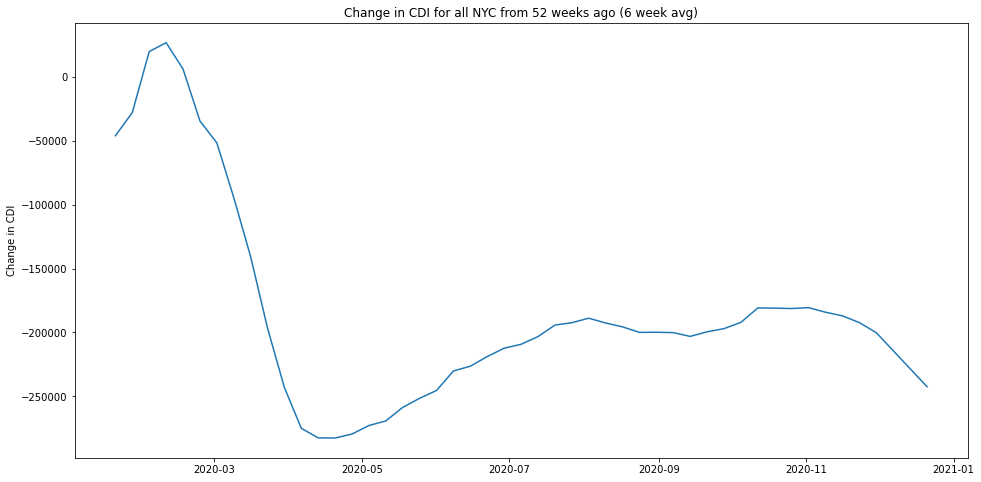

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('Change in CDI for all NYC from 52 weeks ago (6 week avg)')
ax.set_ylabel('Change in CDI')
plt.show()

In [10]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'home_cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['home_cbg', 'cluster', 'population']]
cbg_df.head()

,home_cbg,cluster,population
0,360050001001,2,6864
1,360050002001,2,1744
2,360050002002,2,1569
3,360050002003,3,1219
4,360050004001,3,598


In [11]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({
    'population': 'sum'
}).reset_index()
cluster_df

,cluster,population
0,0,1523534
1,1,2016402
2,2,2115896
3,3,2763460


In [12]:
merge_df = home_df.merge(cbg_df, how='inner', on=['home_cbg'])
merge_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,2,1177
1,zzw-225@627-s7r-7dv,2020-09-28 00:00:00-04:00,360470437004,4,20.740088,0.031746,0.031746,0.022657,2,1177
2,222-222@627-wbt-jgk,2019-04-15 00:00:00-04:00,360470437004,4,9.707216,0.019231,0.019231,0.096981,2,1177
3,222-225@627-s4m-w8v,2019-08-19 00:00:00-04:00,360470437004,4,12.455026,0.022099,0.022099,0.000000,2,1177
4,zzy-223@627-s8k-3kf,2020-01-27 00:00:00-05:00,360470437004,4,16.068259,0.029630,0.029630,20.978254,2,1177


In [13]:
cdi_cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({
    'cdi': 'sum'
}).reset_index()
cdi_cluster_df = cdi_cluster_df.merge(cluster_df, how='outer', on=['cluster'])
cdi_cluster_df = cdi_cluster_df.sort_values(by=['date_range_start', 'cluster'])
cdi_cluster_df[
    'cdi_per_capita'] = cdi_cluster_df['cdi'] / cdi_cluster_df['population']
cdi_cluster_df = smoothen_within(cdi_cluster_df,
                                 columns=['cdi', 'cdi_per_capita'],
                                 by='cluster')
cdi_cluster_df.to_csv('./exports/cdi/total_by_cluster.csv')
cdi_cluster_df.head()

,index,date_range_start,cluster,cdi,population,cdi_per_capita
0,0,2018-12-31 00:00:00-05:00,0,NaN,1523534,NaN
0,110,2018-12-31 00:00:00-05:00,1,NaN,2016402,NaN
0,220,2018-12-31 00:00:00-05:00,2,NaN,2115896,NaN
0,330,2018-12-31 00:00:00-05:00,3,NaN,2763460,NaN
1,1,2019-01-07 00:00:00-05:00,0,NaN,1523534,NaN


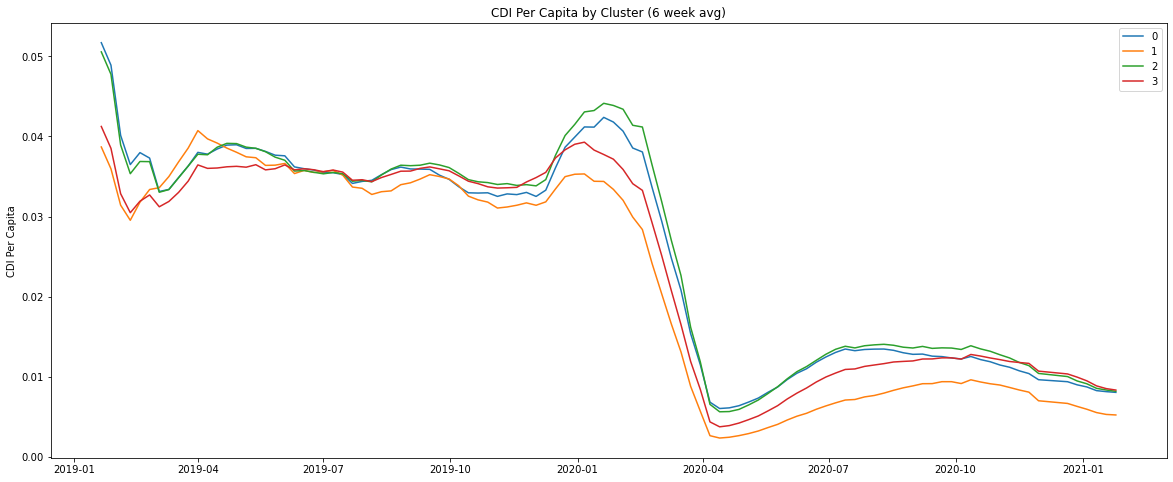

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Cluster (6 week avg)')
ax.set_ylabel('CDI Per Capita')
ax.legend()
plt.show()

In [15]:
cdi_cluster_diff_df = create_diff_df(cdi_cluster_df, keep_columns=['cluster', 'cdi_per_capita'])
cdi_cluster_diff_df.to_csv('./exports/cdi/diff_by_cluster.csv')

,index,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
23,353,2019-06-10 00:00:00-04:00,3,99040.024766,2763460,0.035839,2019,24
24,24,2019-06-17 00:00:00-04:00,0,54816.896764,1523534,0.035980,2019,25
24,134,2019-06-17 00:00:00-04:00,1,72124.011045,2016402,0.035769,2019,25
24,244,2019-06-17 00:00:00-04:00,2,75648.359377,2115896,0.035752,2019,25
24,354,2019-06-17 00:00:00-04:00,3,99412.482007,2763460,0.035974,2019,25
25,25,2019-06-24 00:00:00-04:00,0,54562.215692,1523534,0.035813,2019,26
25,135,2019-06-24 00:00:00-04:00,1,71606.817225,2016402,0.035512,2019,26
25,245,2019-06-24 00:00:00-04:00,2,75183.276610,2115896,0.035533,2019,26
25,355,2019-06-24 00:00:00-04:00,3,99065.191438,2763460,0.035848,2019,26
26,26,2019-07-01 00:00:00-04:00,0,54069.224009,1523534,0.035489,2019,27


,index,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,1,2019-01-07 00:00:00-05:00,0,NaN,1523534,NaN,2019,2
1,111,2019-01-07 00:00:00-05:00,1,NaN,2016402,NaN,2019,2
2,221,2019-01-07 00:00:00-05:00,2,NaN,2115896,NaN,2019,2
3,331,2019-01-07 00:00:00-05:00,3,NaN,2763460,NaN,2019,2
4,2,2019-01-14 00:00:00-05:00,0,NaN,1523534,NaN,2019,3


,index,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,53,2020-01-06 00:00:00-05:00,0,62751.078728,1523534,0.041188,2020,2
1,163,2020-01-06 00:00:00-05:00,1,71233.747454,2016402,0.035327,2020,2
2,273,2020-01-06 00:00:00-05:00,2,91113.690809,2115896,0.043062,2020,2
3,383,2020-01-06 00:00:00-05:00,3,108573.873606,2763460,0.039289,2020,2
4,54,2020-01-13 00:00:00-05:00,0,62718.293167,1523534,0.041166,2020,3


,cdi,cluster,cdi_per_capita,week,date_range_start
0,NaN,0,0.041188,2,2020-01-06 00:00:00-05:00
1,NaN,1,0.035327,2,2020-01-06 00:00:00-05:00
2,NaN,2,0.043062,2,2020-01-06 00:00:00-05:00
3,NaN,3,0.039289,2,2020-01-06 00:00:00-05:00
4,NaN,0,0.041166,3,2020-01-13 00:00:00-05:00


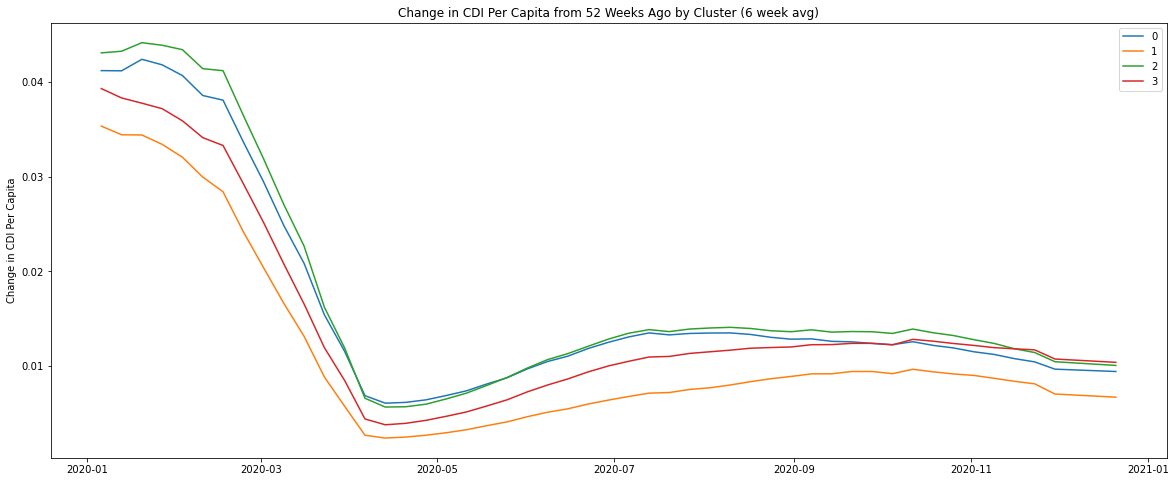

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_diff_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title(
    'Change in CDI Per Capita from 52 Weeks Ago by Cluster (6 week avg)')
ax.set_ylabel('Change in CDI Per Capita')
ax.legend()
plt.show()